# Wrangling WeLoveDogs Tweets

## Overview
The project objective is to gather, assess, clean, store and provide analysis & conclusions on a dataset containing tweets from the WeLoveDogs Twitter account prior to August 1, 2017. Initial tables have been collected and need to be modified, merged and expanded upon in order to arrive at a final clean dataset. The expected output is:
- A .csv file named `twitter_archive_master.csv` containing the final dataframe(s)
- A SQLite database named `twitter_archive_master.db` containing the final dataframe(s)
- A .pdf document named `wrangle_report.pdf` describing the wrangling efforts and framed as an *internal* document
- A .pdf document named `act_report.pdf` displaying visualizations and communicating insights resulting from the analysis and framed as an *external* document

## Table of Contents

- [I. Introduction](#intro)
- [II. Gathering the data](#gather)
- [III. Assessing the data](#assess)
- [IV. Cleaning the data](#clean)
- [V. Storing the data](#store)
- [VI. Analysis](#analysis)
- [VII. Conclusion](#conclusion)

<a id='intro'></a>
### I. Introduction

In [228]:
# Importing necessary libraries for the exercise

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tweepy
from sqlalchemy import create_engine
import datetime
%matplotlib inline

<a id='gather'></a>
### II. Gathering the Data

#### II.a - Reading in the `twitter-archive-enhanced.csv` File

In [229]:
# Reading in the .csv file as a dataframe

df_csv = pd.read_csv('twitter-archive-enhanced.csv')

In [230]:
df_csv.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [231]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### II.b - Reading in the `image-predictions.tsv` File

In [232]:
# Storing the .tsv file in the local directory

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
print(r)

<Response [200]>


In [233]:
df_tsv = pd.read_table(url, sep='\t')

In [234]:
df_tsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [235]:
df = df_csv.merge(df_tsv, on='tweet_id', how='inner')

In [236]:
df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#### II.c - Reading in Data from the Twitter API 

In [151]:
# Authenticate Twitter API - REMOVED

consumer_key = 'xxx'
consumer_secret = 'xxx'
access_token = 'xxx'
access_secret = 'xxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [152]:
api = tweepy.API(auth)

In [71]:
# Get the user ID to be used as a parameter to collect tweets 
user_id = api.get_user('WeLoveDogs')._json['id']

In [505]:
# Cast the tweet IDs in the dataframe into a list
tweets = list(df.tweet_id)

In [ ]:
# Collect and store all JSON associated with a tweet into a list
# Store all errors in a dictionary

tweet_json = []
tweet_json_errors = {}
for t in tweets:
    try:
        data = api.get_status(id=t, 
                              wait_on_rate_limit=True, wait_on_rate_limit_notify=True,
                              tweet_mode = 'extended')._json
        tweet_json.append(data)
    except Exception as e:
        tweet_json_errors[str(t)] = [str(e), data]

In [ ]:
# Write the list of tweets collected from the API to a txt file 

with open('tweet_json.txt', encoding='utf-8', mode='w') as file:
    json.dump(tweet_json, file)

In [237]:
tweet_json2 = []

with open('tweet_json.txt', encoding='utf-8', mode='r') as f:
    json_txt=json.load(f)
    for line in json_txt:
        tweet_id = line['id']
        tweet_likes = line['favorite_count']
        tweet_retweets = line['retweet_count']
        followers = line['user']['followers_count']
        tweet_json2.append({'tweet_id': tweet_id, 
                            'likes': tweet_likes, 
                            'retweets': tweet_retweets, 
                            'followers': followers})

df_twitter = pd.DataFrame(tweet_json2, columns=['tweet_id', 'likes', 'retweets', 'followers'])

In [238]:
df = df.merge(df_twitter, on='tweet_id', how='inner')

<a id='assess'></a>
### III. Assessing the Data

#### III.a - Issue Validation

A list of some potential issues with the data has already been compiled:
- Inaccurate ratings (data quality)
- Inaccurate dog names (data quality)
- Inaccurate dog stages (data quality)

These issues will be validated below.

In [239]:
# Validate dog rating issue 
# Create a dataframe with ratings isolated from 'text' column

nums = [] # Numerators
denoms = [] # Denominators

ratings = df['text'].str.extract(r'(\d+/\d+)', expand=False)

for rating in ratings:
    num, denom = (str(rating).split('/'))
    nums.append(num)
    denoms.append(denom)

df_ratings = pd.DataFrame({'numerator': nums, 'denominator': denoms}, dtype=int)

In [240]:
# Slice out ratings from df and rename columns in order to compare with .equals method

df_ratings_comp = df[['rating_numerator','rating_denominator']]
df_ratings_comp.rename({'rating_numerator': 'numerator','rating_denominator': 'denominator'}, axis=1, inplace=True)

df_ratings.equals(df_ratings_comp)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


True

Despite the project guidelines stating *"The ratings probably aren't all correct"*, they are in fact all correct.

In [241]:
# Validate the dog name issue

df.name.value_counts().head(20)

None       573
a           55
Cooper      10
Penny       10
Charlie     10
Oliver      10
Tucker      10
Lucy         9
Winston      8
Lola         8
Sadie        8
Bo           8
an           7
the          7
Daisy        7
Toby         7
Rusty        6
Stanley      6
Dave         6
Jax          6
Name: name, dtype: int64

As suspected, multiple dogs have been misidentified as having a name that is an English lowercase word ('a', 'an', 'the', etc.).

In [242]:
# Validate the dog stage issue
# To make things easier, we will collapse (melt) the dog stage columns into a single column
# This corresponds to the first part of IV.f - Melt the Dog Stages

df_stage = df.melt(id_vars='tweet_id', value_vars=['doggo', 'floofer', 'pupper', 'puppo'], value_name='stage')

In [243]:
# Merge the melted stage column to df

df_stage = df_stage[df_stage['stage']!='None'].drop('variable', axis=1)
df = df.merge(df_stage, how='left')

In [244]:
# Validate existence of the dog stage in the text column

df.stage.fillna('None', inplace=True)
filt_stage = df[df['stage']!='None'].index
df.iloc[filt_stage].apply(lambda x: x.stage.lower() in x.text.lower(), axis=1).value_counts()

True    331
dtype: int64

Despite the project guidelines stating that *"The ratings probably aren't all correct. Same goes for the dog names and probably dog stages"*, the dog stages seem to all be correct (all dog stages are present in the corresponding `text` field).

#### III.b - Programmatic Assessment

Next, the project requirements ("key points") pose an additional limitation on the target dataset, which translates into a potential assessment point:
- Tweets must be original ratings with images - no retweets (data quality)

This and other potential issues will be assessed programmatically below.

In [245]:
# Programmatically assess the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2071 entries, 0 to 2070
Data columns (total 32 columns):
tweet_id                      2071 non-null int64
in_reply_to_status_id         24 non-null float64
in_reply_to_user_id           24 non-null float64
timestamp                     2071 non-null object
source                        2071 non-null object
text                          2071 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2071 non-null object
rating_numerator              2071 non-null int64
rating_denominator            2071 non-null int64
name                          2071 non-null object
doggo                         2071 non-null object
floofer                       2071 non-null object
pupper                        2071 non-null object
puppo                         2071 non-null object
jpg_url                       2071 

A simple `.info` method call identifies the following issues:
- There are null values in some fields
- As suspected, the table contains retweets and replies as indicated by multiple columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- The `tweet_id` column is an integer (data quality)
- The `timestamp` column is a string (data quality)
- The `doggo`, `floofer`, `pupper` and `puppo` columns all convey the dog stage (data tidyness)
- The prediction columns (`p1` through `p3_dog`) present multiple columns with the same purpose and violate the rules of tidy data (data tidyness). Also, they are not named appropriately (data quality)

#### III.c - Visual Assessment

In [246]:
# Write the dataframe to a .csv file to be assessed visually

df.to_csv('/'.join([os.path.abspath(os.getcwd()), 'df.csv']), index=False)

The additional issues highlighted during the visual assessment are:
- The format of the names of the dog breeds is not consistent: single word breeds are capitalized while two-word breeds are not capitalized and contain underscores instead of spaces
- The `text` column contains a shortened URL which  belongs in another field (data quality) and conveys the same information as the `exapanded_urls` column (data tidyness)
- In some instances, the `expanded_urls` column contains multiple entries of the same url separated by a column (data quality)

#### III.d - Summary of Issues

In total, 8 data quality issues and 3 data tidyness issues have been identified above and will be cleaned in the next section.

##### Data Quality Issues

1. There are null values in some columns
2. Some dog names are inaccurate
3. Some observations are replies and retweets
4. The `tweet_id` field isn't the correct data type
5. The `timestamp` field isn't the correct data type
6. The format of dog breed is inconsistent
7. There are URLs present in the `text` field
8. The `expanded_urls` contains duplicate entries in the same observation

##### Data Tidyness Issues

1. There are multiple dog stages columns
2. There are multiple prediction columns
3. The same link is present in the `text` field as in the `expanded_urls` field (same issue as *data quality* #7)

<a id='clean'></a>
### IV - Cleaning the Data

The issues identified above will be cleaned one by one.

In [247]:
# Copy the dataframe as df_original and work with df

df_original = df.copy()

#### IV.a - Null Values

##### Define

Replace null values in the dataframe with 'None'.

##### Code

In [248]:
# Replace null values with 'None'

df.fillna('None', inplace=True)

##### Test

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2071 entries, 0 to 2070
Data columns (total 32 columns):
tweet_id                      2071 non-null int64
in_reply_to_status_id         2071 non-null object
in_reply_to_user_id           2071 non-null object
timestamp                     2071 non-null object
source                        2071 non-null object
text                          2071 non-null object
retweeted_status_id           2071 non-null object
retweeted_status_user_id      2071 non-null object
retweeted_status_timestamp    2071 non-null object
expanded_urls                 2071 non-null object
rating_numerator              2071 non-null int64
rating_denominator            2071 non-null int64
name                          2071 non-null object
doggo                         2071 non-null object
floofer                       2071 non-null object
pupper                        2071 non-null object
puppo                         2071 non-null object
jpg_url                      

#### IV.b - Dog Names

##### Define

Replace observations with false dog names with 'None'.

##### Code

In [250]:
# Replace English lower case letter dog names

df['name'].replace(regex=r'^[a-z]', value='None', inplace=True)

##### Test

In [251]:
# Test lower case word names

(df['name'].str.contains(r'^[a-z]').value_counts())

False    2071
Name: name, dtype: int64

#### IV.c - Retweets & Replies

##### Define

Filter out replies and retweets from the dataframe.

##### Code

In [252]:
# Filter out replies

replies = df[df['in_reply_to_status_id']!='None'].index
df.drop(replies, inplace=True)

In [253]:
# Filter out retweets

retweets = df[df['retweeted_status_id']!='None'].index
df.drop(retweets, inplace=True)

In [254]:
# Drop reply and retweet columns

df.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

In [255]:
df.reset_index(drop=True, inplace=True)

##### Test

In [256]:
# Test by checking shape

df_original.shape, df.shape

((2071, 32), (1973, 27))

#### IV.d - `tweet_id` Column Data Type

##### Define

Change the `tweet_id` column data type from integer to string.

##### Code

In [257]:
df.tweet_id = df.astype(str)

##### Test

In [258]:
# Test by comparing first row's datatype in the working df vs the original df

type(df.tweet_id.iloc[0]), type(df_original.tweet_id.iloc[0])

(str, numpy.int64)

#### IV.e - `Timestamp` Column Data Type

##### Define

Change the `timestamp` column data type from string to datetime.

##### Code

In [259]:
df.timestamp = pd.to_datetime(df.timestamp)

##### Test

In [260]:
# Test by comparing first row's datatype in the working df vs the original df

type(df.timestamp.iloc[0]), type(df_original.timestamp.iloc[0])

(pandas._libs.tslibs.timestamps.Timestamp, str)

#### IV.f - Format of Dog Breed

##### Define

Format the dog breeds such that the first letter is capitalized and there are no underscores.

##### Code

In [261]:
def format_breed(breed):
    breed = breed.replace('_', ' ')
    breed = breed[0].upper()+breed[1:]
    return breed

In [262]:
df[['p1', 'p2', 'p3']] = df[['p1', 'p2', 'p3']].applymap(format_breed)

##### Test

In [263]:
df[['p1', 'p2', 'p3']].head(10)

,p1,p2,p3
0,Orange,Bagel,Banana
1,Chihuahua,Pekinese,Papillon
2,Chihuahua,Malamute,Kelpie
3,Paper towel,Labrador retriever,Spatula
4,Basset,English springer,German short-haired pointer
5,Chesapeake Bay retriever,Irish terrier,Indian elephant
6,Appenzeller,Border collie,Ice lolly
7,Pomeranian,Eskimo dog,Pembroke
8,Irish terrier,Irish setter,Chesapeake Bay retriever
9,Pembroke,Cardigan,Chihuahua


#### IV.g - URLs in `text` Column

##### Define

Keep only the string to the left of the URL in the `text` column.

##### Code

In [264]:
df['text'] = df['text'].apply(lambda x: x.split(' https://')[0])

##### Test

In [265]:
# Test by sampling five random rows to assess the presence of URLs

for index, row in df.sample(5).iterrows():
    print(index, row[3])

1238 Meet Trooper &amp; Maya. Trooper protects Maya from bad things like dognappers and Comcast. So touching. 11/10 for both
1272 For the last time, WE. DO. NOT. RATE. BULBASAUR. We only rate dogs. Please only send dogs. Thank you ...9/10
1428 In honor of the new Star Wars movie. Here's Yoda pug. 12/10 pet really well, would I
1078 This is Daniel. He's a neat pup. Exotic af. Custom paws. Leaps unannounced. Would totally pet. 7/10 daaamn Daniel
1572 This is Dot. He found out you only pretended to throw the ball that one time. You don't fuck with Dot. 8/10


#### IV.h - Duplicate URLs in `expanded_urls` Column

##### Define

Remove the instances of a duplicate URL in the `expanded_urls` column.

##### Code

In [266]:
df['expanded_urls'] = df['expanded_urls'].apply(lambda x: x.split(',')[0])

##### Test

In [267]:
# Test by comparing observations with duplicate URLs in original datafram with new dataframe

sample_duplicate_url_index = list(df_original[df_original['expanded_urls'].str.contains(',')].index[:3])
df.iloc[sample_duplicate_url_index]['expanded_urls'].str.contains(',')

4    False
6    False
7    False
Name: expanded_urls, dtype: bool

#### IV.i - Multiple Dog Stages Columns

##### Define

Create a single column containing the stage for each dog (if available). 

**Note:** most of this step was completed in **III.a - Issue Validation & Programmatic Assessment** in order to assess the issue raised in the project guidelines more easily. Below, the process will be completed by dropping the superfluous columns.

##### Code

In [268]:
stage_list = df[['doggo', 'floofer','pupper', 'puppo']]
df.drop(columns=stage_list, inplace=True)

##### Test

In [269]:
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'likes', 'retweets', 'followers', 'stage'],
      dtype='object')

#### IV.j - Prediction Columns

##### Define

The prediction columns will be cleaned such that the only columns remaining will be:
- `prediction_breed`: the breed of the prediction that has the highest confidence level and that is also a dog type
- `prediction_confidence`: the confidence level of the prediction in `prediction_breed`

**Note:** this operation resolves *data quality* issue #7 and *data tidyness* issue #3.

##### Code

In [270]:
# Create a dataframe with only the prediction columns

preds_original = df[['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]

In [271]:
# Create a dataframe with the most confident dog prediction and confidence for each observation

predictions = []

for index, row in preds_original.iterrows():
    if row[2] == True:
        predictions.append([row[0], row[1]])
    elif row[2] == False & row[5] == True:
        predictions.append([row[3], row[4]])
    elif row[2] == False & row[5] == False & row[8] == True:
        predictions.append([row[6], row[7]])
    else:
        predictions.append(['Undefined', 'Undefined'])
        
preds_df = pd.DataFrame(predictions, columns=['prediction_breed', 'prediction_confidence'])

In [272]:
# Join preds_df with df

df = df.merge(preds_df, left_index=True, right_index=True, validate='1:1', how='inner')

In [273]:
# Validate shape to ensure no observations were omitted and that two columns have been added to df

df_original.shape, df.shape

((2071, 32), (1973, 25))

##### Test

In [274]:
# Test by comparing the previous prediction columns (p1-p3_dog) with the new prediction columns

df[['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'prediction_breed', 'prediction_confidence']].head()

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,prediction_breed,prediction_confidence
0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,Undefined,Undefined
1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,Chihuahua,0.323581
2,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,Chihuahua,0.716012
3,Paper towel,0.170278,False,Labrador retriever,0.168086,True,Spatula,0.040836,False,Undefined,Undefined
4,Basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,Basset,0.555712


In [275]:
# Drop superfluous columns

df.drop(columns=['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

#### IV.k - Link in `text` and `expanded_urls` Columns

**Note:** this issue was resolved in **IV.g - URLs in `text` Column**.

#### IV.l - Rearrange Columns

The columns will be arranged per my personal preference.

In [276]:
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'likes', 'retweets', 'followers', 'stage', 'prediction_breed',
       'prediction_confidence'],
      dtype='object')

In [277]:
df = df[['tweet_id', 'timestamp', 'text', 'img_num', 'rating_numerator', 'rating_denominator', 'name', 'stage', 'likes', 'retweets', 'prediction_breed', 'prediction_confidence', 'followers', 'expanded_urls', 'jpg_url', 'source']]

<a id='store'></a>
### V. Storing the Data

#### V.a - Storing the Data to a .csv File

In [278]:
# Save the df to a .csv

df.to_csv('twitter_archive_master.csv', index=False)

#### V.b - Storing the Data to a Database

In [279]:
# Create SQLAlchemy Engine and empty twitter_archive_master database

engine = create_engine('sqlite:///twitter_archive_master.db')

In [280]:
# Store the df to the database under the name 'master'

df.to_sql('master', engine, index=False)

ValueError: Table 'master' already exists.

<a id='analysis'></a>
### VI. Analysis

#### VI.a - Account Popularity

In [281]:
# Set the timestamp as the index to facilitate time series analysis

df_time = df.set_index(df['timestamp'])

The number of likes per tweet would be expected to increase over time as the account grows in popularity.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'timestamp' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


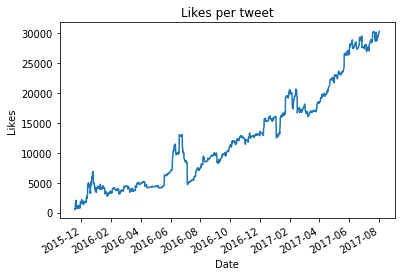

In [282]:
# Calculate & visualize the moving average of likes per tweet 

likes_roll_avg = df_time.sort_values(by='timestamp', ascending=True).likes.rolling(50).mean()
likes_roll_avg.plot()
plt.xlabel('Date')
plt.ylabel('Likes')
plt.title('Likes per tweet');

Clearly, the account popularity has been increasing over time. One possible explanation would be if the number of followers has increased over the period of analysis.

In [283]:
# Calculate the period of analysis
period = round((df_time.sort_values(by='timestamp', ascending=True).timestamp.iloc[-1] - df_time.sort_values(by='timestamp', ascending=True).timestamp.iloc[0]).days/365, 1)

# Calculate the net number of followers gained over the period
followers_delta = df_time.sort_values(by='timestamp', ascending=True).followers.iloc[-1] - df_time.sort_values(by='timestamp', ascending=True).followers.iloc[0]

print('The net number of followers gained/lost is {followers} over the {period} years analyzed'.format(followers=followers_delta, period=period))

The net number of followers gained/lost is -21 over the 1.7 years analyzed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'timestamp' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'timestamp' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


In [284]:
# Calculate min and max followers over the period

(df_time.followers.min(), df_time.followers.max())

(8744532, 8744881)

Interestingly, the number of followers seems to have remained relatively constant over the period. Another possible explanation would be that the account has been posting more regularly.

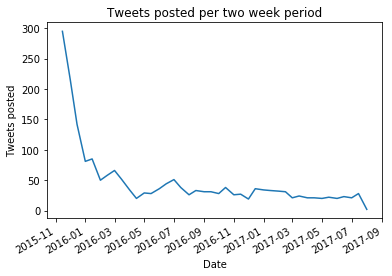

In [285]:
# Calculate & visualize the number of tweets posted per two week period

tweets_per_week = df_time.resample('SMS').count()['tweet_id']
tweets_per_week.plot()
plt.xlabel('Date')
plt.ylabel('Tweets posted')
plt.title('Tweets posted per two week period');

The post volume was initially quite high, but then declined steeply after the first few weeks of the period. It then slowly declined over the following year and a half. Interestingly, the bi-weekly tweet volume appears to be inversely related to the likes count.

#### VI.b - Popularity & Rating by Dog Stage

Next, an analysis will be performed to evaluate which dog stage is most popular among followers and which dog stage is rated the hightest by the account.

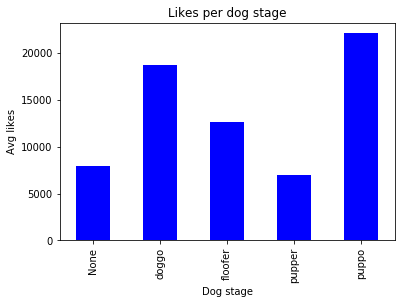

In [286]:
# Calculating & visualizing avg likes per dog stage

likes_per_stage = df_time.groupby('stage')['likes'].sum()/df_time.groupby('stage')['likes'].count()

likes_per_stage.plot(kind='bar', colormap='winter')
plt.title('Likes per dog stage')
plt.xlabel('Dog stage')
plt.ylabel('Avg likes');

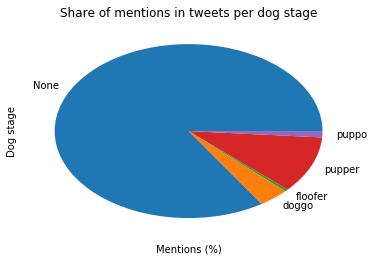

In [287]:
count_per_stage = df_time.groupby('stage')['likes'].count()/df_time.groupby('stage')['likes'].count().sum()

count_per_stage.plot('pie')
plt.xlabel('Mentions (%)')
plt.ylabel('Dog stage')
plt.title('Share of mentions in tweets per dog stage');

While puppos receive the most likes on average, this dog stage has also received a very small share (1%) of all tweets relative to other dog stages.

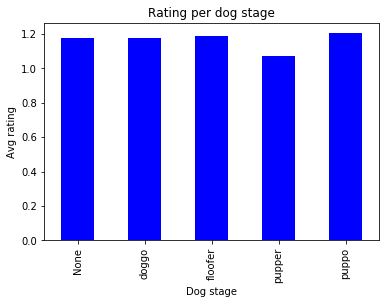

In [288]:
# Calculating & visualizing avg rating per dog stage

rating_per_stage = df_time.groupby('stage')['rating_numerator'].sum()/df_time.groupby('stage')['rating_denominator'].sum()

rating_per_stage.plot(kind='bar', colormap='winter')
plt.title('Rating per dog stage')
plt.xlabel('Dog stage')
plt.ylabel('Avg rating');

Puppos also receive the hightest ratings from the account, although the variance in mean rating is much smaller than the variance in mean like count.

<a id='conclusion'></a>
### VII. Conclusion

This project has been mainly an exercise in gathering, assessing and cleaning data from the WeLoveDogs Twitter account. This process rendered the dataset more concise by eliminating half the columns and more relevant by keeping the rows and data that lends itself to easily be shared and analyzed. 